In [ ]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, roc_auc_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay

In [2]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
x, y = mnist['data'], mnist['target']
x.shape, y.shape

((70000, 784), (70000,))

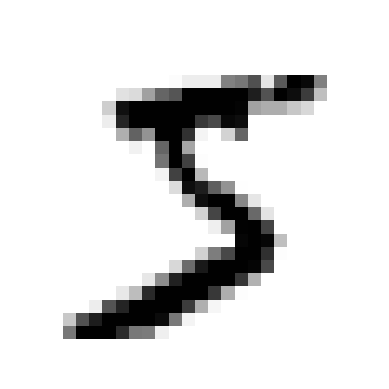

In [4]:
some_dgt = x[0]
some_dgt_img = some_dgt.reshape(28,28)

plt.imshow(some_dgt_img, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
y = y.astype(np.uint8)

In [7]:
x_train, x_test, y_train, y_test = x[:60000], x[60000:], y[:60000], y[60000:]

### Binary classifier for only detecting 5

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
# simple SGDClf
sgd_clf = SGDClassifier()
sgd_clf.fit(x_train, y_train_5)

SGDClassifier()

In [10]:
sgd_clf.predict([some_dgt])

array([ True])

In [11]:
# performance measure
skfolds = StratifiedKFold(n_splits=3)

for train_idx, test_idx in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_clf)

    x_train_folds = x_train[train_idx]
    x_test_folds = x_train[test_idx]
    y_train_folds = y_train_5[train_idx]
    y_test_folds = y_train_5[test_idx]

    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.96275
0.96825
0.9438


In [12]:
# using cross_val_score
cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.9672 , 0.9548 , 0.95495])

In [13]:
y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

In [14]:
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [15]:
confusion_matrix(y_train_5, y_train_pred)

array([[52808,  1771],
       [  914,  4507]])

In [16]:
# this is added to get the decision scores instead of values like True, False, etc
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method='decision_function')

In [17]:
# precision recall curve
precisions, recalls, threshs = precision_recall_curve(y_train_5, y_scores)

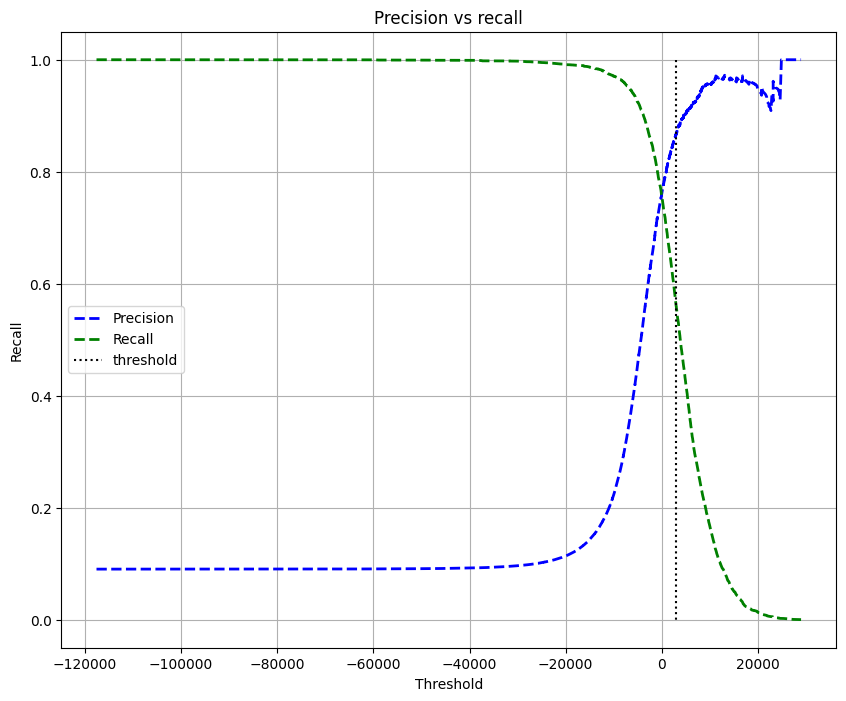

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(threshs, precisions[:-1], "b--", label="Precision", linewidth=2)
ax.plot(threshs, recalls[:-1], "g--", label="Recall", linewidth=2)
ax.vlines(3000, 1.0, 0, "k", "dotted", label="threshold")
ax.set(xlabel='Threshold', ylabel='Recall', title='Precision vs recall')
ax.legend(loc='center left')
ax.grid()
plt.show()

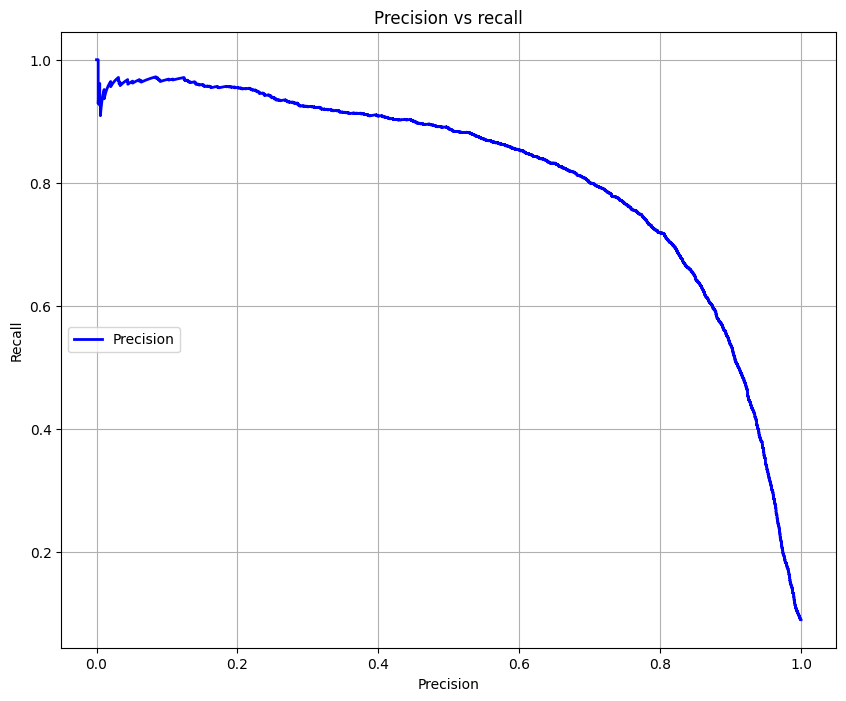

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(recalls, precisions, "b", label="Precision", linewidth=2)
ax.set(xlabel='Precision', ylabel='Recall', title='Precision vs recall')
ax.legend(loc='center left')
ax.grid()
plt.show()

### TPR vs FPR --> ROC Curve

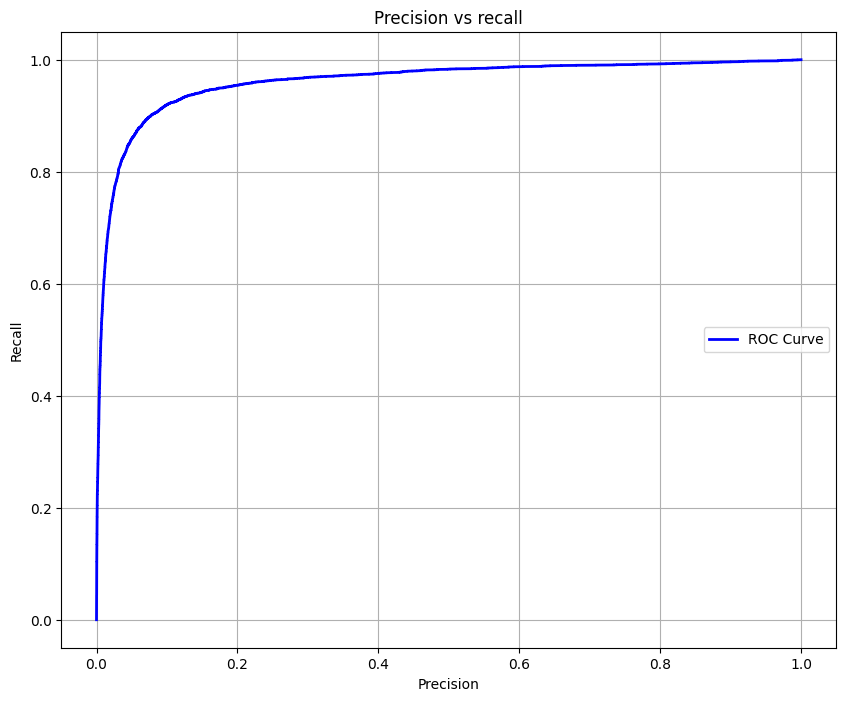

In [20]:
fpr, tpr, threshs = roc_curve(y_train_5, y_scores)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr, tpr, "b", label="ROC Curve", linewidth=2)
ax.set(xlabel='Precision', ylabel='Recall', title='Precision vs recall')
ax.legend(loc='center right')
ax.grid()
plt.show()

In [21]:
# roc auc area
roc_auc_score(y_train_5, y_scores)

0.9610576416735952

## Making a RandomForest Classifier

In [22]:
rnd_frst_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(rnd_frst_clf, x_train, y_train_5, cv=3, method="predict_proba")

In [23]:
y_probas_forest[:,1]

array([0.89, 0.02, 0.04, ..., 0.98, 0.08, 0.07])

In [24]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.98, 0.02]])

In [25]:
# plotting both SGD and Rndm Frst Clf
y_scores_frst = y_probas_forest[:, 1]
precisions_frst, recalls_frst, threshs_frst = precision_recall_curve(y_train_5, y_scores_frst)

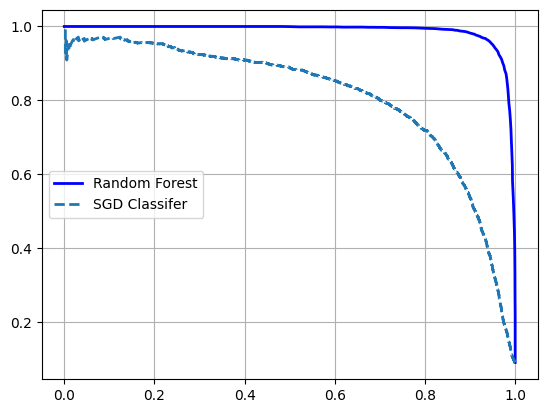

In [26]:
plt.plot(recalls_frst, precisions_frst, "b-", linewidth=2, label='Random Forest')
plt.plot(recalls, precisions, "--", linewidth=2, label='SGD Classifer')
plt.legend(loc='center left')
plt.grid()
plt.show()

In [27]:
y_train_pred_frst = y_probas_forest[:,1] >= 0.5
f1_score(y_train_5, y_train_pred_frst)

0.9270445185330457

In [28]:
roc_auc_score(y_train_5, y_scores_frst)

0.9983296721818179

In [29]:
precision_score(y_train_5, y_train_pred_frst), recall_score(y_train_5, y_train_pred_frst)

(0.9895331798199707, 0.8719793396052389)

## Multiclass classification

In [30]:
svm_clf = SVC(random_state=42)
svm_clf.fit(x_train[:2000], y_train[:2000])

SVC(random_state=42)

In [31]:
svm_clf.predict([some_dgt])

array([5], dtype=uint8)

In [32]:
# decision function to show that SVM Clf made 45 predictions
some_dgt_scores = svm_clf.decision_function([some_dgt])
some_dgt_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [33]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [34]:
# one vs rest clf
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(x_train[:2000], y_train[:2000])
print(ovr_clf.predict([some_dgt]))
print(len(ovr_clf.estimators_))

[5]
10


In [35]:
# SGD using OvR
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_dgt])

array([3], dtype=uint8)

In [36]:
sgd_clf.decision_function([some_dgt]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [37]:
# simple scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

### Error Analysis

In [38]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

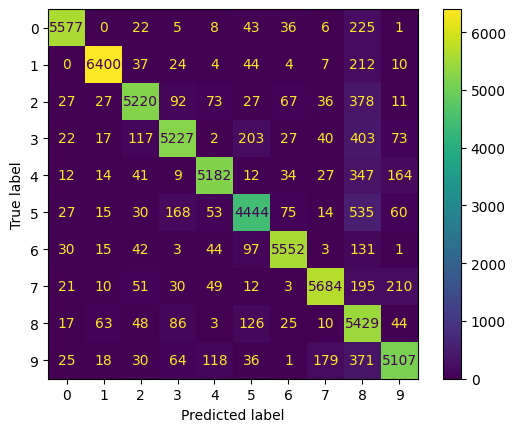

In [39]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

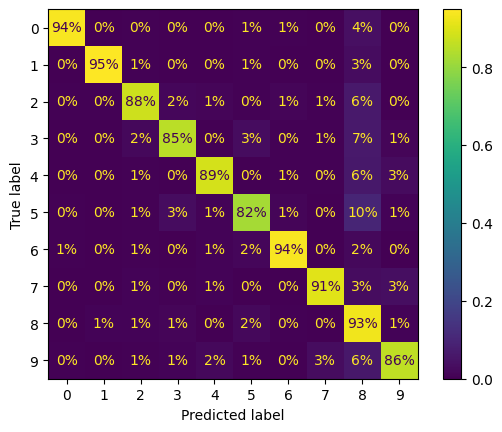

In [40]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%")
plt.show()

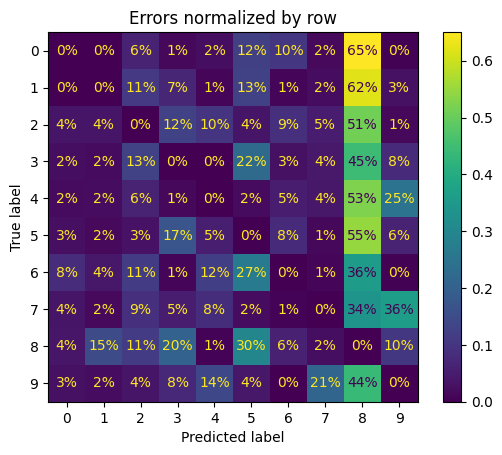

In [41]:
sample_wt = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_wt, normalize='true', values_format='.0%')
plt.title('Errors normalized by row')
plt.show()

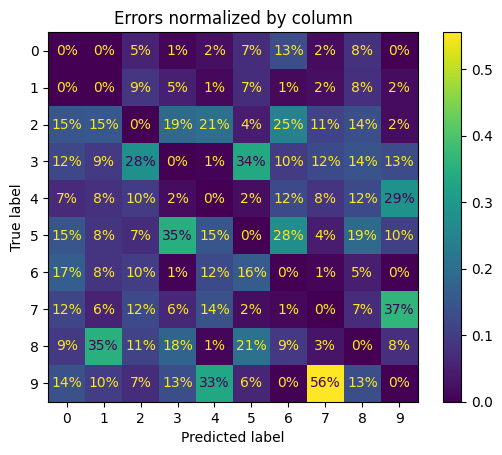

In [42]:
sample_wt = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_wt, normalize='pred', values_format='.0%')
plt.title('Errors normalized by column')
plt.show()

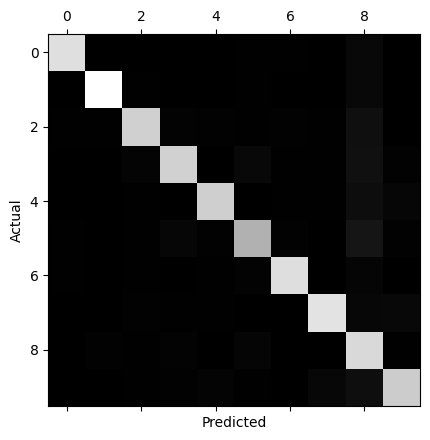

In [43]:
### For a moment ignore the above 4 confusion matrix display
### lets just use the confusion_mx created before
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#### Tip
- There are different classes of each digit, hence will need to normalise or divide by the actual number of classes -->  to get error rates instead of absolute number of errors

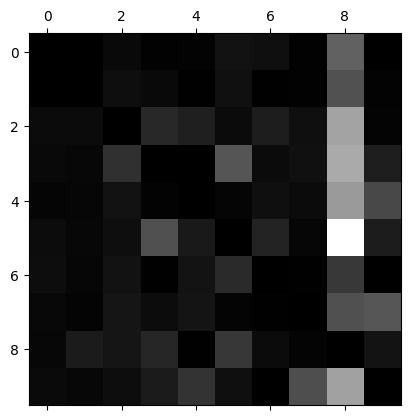

In [44]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# fill diagonal with zeros
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

## Multioutput classification

In [ ]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [45]:
noise = np.random.randint(0, 100, (len(x_train), 784))
x_train_mod = x_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

In [46]:
type(x_train[0].reshape(28,28))

numpy.ndarray

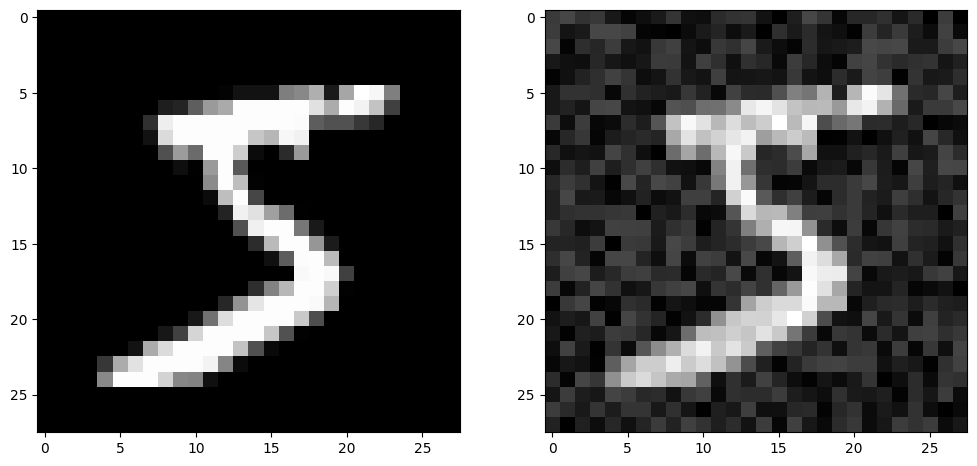

In [47]:
fig, ax = plt.subplots(1,2, figsize=(12,10))
ax[0].imshow(x_train[0].reshape(28,28), cmap='gray')
ax[1].imshow(x_train_mod[0].reshape(28,28), cmap='gray')
plt.show()

In [48]:
# creating a KNNClf
knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train_mod, y_train_mod)
clean_dgt = knn_clf.predict([x_test_mod[0]])

plt.imshow(clean_dgt[0].reshape(28,28), cmap='gray')
plt.show()

NameError: name 'KNeighborsClassifier' is not defined